In [1]:
# ===============================
# Phase 4 — User Behavior Prediction
# Cell 1: Load Dataset
# ===============================

import pandas as pd
import numpy as np
from pathlib import Path

# ---------------- Paths (relative to notebook location) ----------------
# Try to detect project root - works if notebook is in notebooks/ subdirectory
current_dir = Path.cwd()
if current_dir.name == "notebooks":
    PROJECT_ROOT = current_dir.parent
elif (current_dir / "notebooks").exists():
    PROJECT_ROOT = current_dir
else:
    # Fallback: assume we're in project root
    PROJECT_ROOT = current_dir

DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
SEGMENTS_FILE = DATA_PROCESSED_DIR / "user_segments_final.csv"

# Validate file exists
if not SEGMENTS_FILE.exists():
    raise FileNotFoundError(f"Segments file not found: {SEGMENTS_FILE}")

# ---------------- Load dataset ----------------
print(f"Loading dataset from: {SEGMENTS_FILE}")
df = pd.read_csv(SEGMENTS_FILE)

# ---------------- Inspect dataset ----------------
print("Dataset loaded:", df.shape)
print(df.head())
print("\nColumns info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe(include='all'))


Loading dataset from: c:\Users\ASUS\Desktop\user_behavior_project\data\processed\user_segments_final.csv
Dataset loaded: (5000, 35)
   avg_session_duration  avg_events_per_session  avg_pages_per_session  \
0             -0.369743               -0.005979               0.139124   
1              0.990656               -1.223669              -0.533526   
2             -1.009072               -0.361138              -1.273440   
3             -0.492354               -1.781777              -2.686004   
4              1.619558               -0.208927               0.273654   

   total_clicks  total_scrolls  total_add_to_cart  total_purchases  \
0     -0.418231      -0.340704           0.487233        -0.425778   
1     -0.062399       0.532784          -0.426215        -0.425778   
2     -0.774063      -0.340704          -0.426215        -0.425778   
3     -0.418231      -0.777448          -0.426215        -0.425778   
4      0.578099       0.096040          -0.426215        -0.425778   

  

In [2]:
# ===============================
# Phase 4 — User Behavior Prediction
# Cell 2: Create Target Labels (CORRECTED)
# ===============================

# ---------------- Use existing df or reload if needed ----------------
if 'df' not in dir() or df is None:
    FEATURES_FILE = DATA_PROCESSED_DIR / "features_user_ml.csv"
    if not FEATURES_FILE.exists():
        raise FileNotFoundError(f"Features file not found: {FEATURES_FILE}")
    df = pd.read_csv(FEATURES_FILE)
    print(f"Loaded features from: {FEATURES_FILE}")
else:
    print("Using existing df from previous cell")

# 2. Load SESSIONS to calculate Retention (The missing piece)
# We need to count how many sessions each user actually had
SESSIONS_FILE = DATA_PROCESSED_DIR / "session_features.csv"
if not SESSIONS_FILE.exists():
    # Fallback: try raw sessions file
    SESSIONS_FILE = PROJECT_ROOT / "data" / "raw" / "sessions_raw.csv"
    if not SESSIONS_FILE.exists():
        raise FileNotFoundError(f"Sessions file not found. Tried: {DATA_PROCESSED_DIR / 'session_features.csv'} and {SESSIONS_FILE}")

sessions_df = pd.read_csv(SESSIONS_FILE)
print(f"Loaded sessions from: {SESSIONS_FILE}")

# Calculate session counts per user
user_session_counts = sessions_df['user_id'].value_counts()

# ---------------- Create Labels ----------------

# Target A: Bounce (Did the user bounce?)
# Logic: If bounce_rate > 0 (standardized or raw), it indicates a bounce happened
df['y_bounce'] = np.where(df['bounce_rate'] > 0, 1, 0)

# Target B: Conversion (Did the user buy?)
# Logic: Check if total_purchases > 0 (works for both raw and standardized values)
# For standardized values, we check if > 0 (which means above mean)
# For raw values, we check if > 0 (which means at least 1 purchase)
# More robust: check if value is greater than the median of all values
purchase_median = df['total_purchases'].median()
df['y_convert'] = np.where(df['total_purchases'] > purchase_median, 1, 0)

# Target C: Retention (Did the user return?)
# Map the real session counts from sessions_df to this dataframe
# We assume 'user_id' exists in df. If not, we might need to rely on index if sorted.
if 'user_id' in df.columns:
    # Map the counts to the user_id
    df['real_session_count'] = df['user_id'].map(user_session_counts)
    # If count > 1, they returned
    df['y_return'] = np.where(df['real_session_count'] > 1, 1, 0)
    # Drop the helper column
    df.drop(columns=['real_session_count'], inplace=True)
else:
    print("CRITICAL WARNING: 'user_id' column missing from features file. Cannot map returning users reliably.")
    # Fallback: If rows are perfectly aligned 1-to-1 with users
    # df['y_return'] = np.where(user_session_counts.sort_index().values > 1, 1, 0)

# ---------------- Check Distributions ----------------
print("Bounce label distribution:\n", df['y_bounce'].value_counts())
print("\nConvert label distribution:\n", df['y_convert'].value_counts())
print("\nReturn label distribution:\n", df['y_return'].value_counts())

# ---------------- Save Targets ----------------
# Save ONLY the ID and Targets to avoid data duplication
# Ensure user_id is included
output_columns = ["y_bounce", "y_convert", "y_return"]
if "user_id" in df.columns:
    output_columns.insert(0, "user_id")

targets_output = df[output_columns]

TARGETS_FILE = DATA_PROCESSED_DIR / "user_targets.csv"
targets_output.to_csv(TARGETS_FILE, index=False)
print(f"\n✓ Target labels saved to {TARGETS_FILE}")
print(f"\nLabel distributions:")
print(f"  Bounce: {df['y_bounce'].value_counts().to_dict()}")
print(f"  Convert: {df['y_convert'].value_counts().to_dict()}")
print(f"  Return: {df['y_return'].value_counts().to_dict()}")

Using existing df from previous cell
Loaded sessions from: c:\Users\ASUS\Desktop\user_behavior_project\data\processed\session_features.csv
Bounce label distribution:
 y_bounce
0    4652
1     348
Name: count, dtype: int64

Convert label distribution:
 y_convert
0    3960
1    1040
Name: count, dtype: int64

Return label distribution:
 y_return
1    4816
0     184
Name: count, dtype: int64

✓ Target labels saved to c:\Users\ASUS\Desktop\user_behavior_project\data\processed\user_targets.csv

Label distributions:
  Bounce: {0: 4652, 1: 348}
  Convert: {0: 3960, 1: 1040}
  Return: {1: 4816, 0: 184}


In [3]:
# ===============================
# Phase 4 — User Behavior Prediction
# Cell 3: Train/Test Split (CORRECTED - Fixed Split Alignment)
# ===============================

from sklearn.model_selection import train_test_split

# ---------------- Verify required columns exist ----------------
# Features: We removed 'total_purchases' and 'bounce_rate' to prevent cheating (Data Leakage)
# Check which device/traffic columns actually exist
available_cols = df.columns.tolist()

# Base feature columns (always present)
base_features = [
    'avg_session_duration', 
    'avg_events_per_session', 
    'avg_pages_per_session',
    'total_clicks', 
    'total_scrolls', 
    'total_add_to_cart'  # This is okay (it's an action, not the final purchase)
]

# Device type columns (check which ones exist)
device_cols = []
for col in ['device_type_desktop', 'device_type_mobile', 'device_type_tablet']:
    if col in available_cols:
        device_cols.append(col)

# Traffic source columns (check which ones exist)
traffic_cols = []
for col in ['traffic_source_ads', 'traffic_source_direct', 'traffic_source_organic', 'traffic_source_referral']:
    if col in available_cols:
        traffic_cols.append(col)

# Combine all feature columns
feature_cols = base_features + device_cols + traffic_cols

# Verify all columns exist
missing_cols = [col for col in feature_cols if col not in available_cols]
if missing_cols:
    raise ValueError(f"Missing feature columns: {missing_cols}")

print(f"Using {len(feature_cols)} features for modeling")
print(f"Feature columns: {feature_cols}")

# Create X (Features)
X = df[feature_cols].copy()

# Targets (must exist from previous cell)
required_targets = ['y_bounce', 'y_convert', 'y_return']
missing_targets = [t for t in required_targets if t not in df.columns]
if missing_targets:
    raise ValueError(f"Missing target columns. Please run Cell 2 first: {missing_targets}")

y_bounce = df['y_bounce']
y_convert = df['y_convert']
y_return = df['y_return']

# ---------------- CRITICAL FIX: Split ONCE for all targets ----------------
# Split X and indices together, then use same indices for all targets
# This ensures the same users are in train/test for all targets
X_train, X_test, train_indices, test_indices = train_test_split(
    X, X.index, test_size=0.2, random_state=42, stratify=y_convert  # Stratify by most balanced target
)

# Use the same train/test indices for all targets
y_bounce_train = y_bounce.iloc[train_indices]
y_bounce_test = y_bounce.iloc[test_indices]

y_convert_train = y_convert.iloc[train_indices]
y_convert_test = y_convert.iloc[test_indices]

y_return_train = y_return.iloc[train_indices]
y_return_test = y_return.iloc[test_indices]

print(f"\n{'='*60}")
print("DATA SPLIT COMPLETE (All targets aligned)")
print(f"{'='*60}")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]} columns")
print(f"\nTarget distributions in training set:")
print(f"  Bounce: {y_bounce_train.value_counts().to_dict()}")
print(f"  Convert: {y_convert_train.value_counts().to_dict()}")
print(f"  Return: {y_return_train.value_counts().to_dict()}")
print(f"\nTarget distributions in test set:")
print(f"  Bounce: {y_bounce_test.value_counts().to_dict()}")
print(f"  Convert: {y_convert_test.value_counts().to_dict()}")
print(f"  Return: {y_return_test.value_counts().to_dict()}")

Using 11 features for modeling
Feature columns: ['avg_session_duration', 'avg_events_per_session', 'avg_pages_per_session', 'total_clicks', 'total_scrolls', 'total_add_to_cart', 'device_type_mobile', 'device_type_tablet', 'traffic_source_direct', 'traffic_source_organic', 'traffic_source_referral']

DATA SPLIT COMPLETE (All targets aligned)
Training set: 4000 samples
Test set: 1000 samples
Features: 11 columns

Target distributions in training set:
  Bounce: {0: 3724, 1: 276}
  Convert: {0: 3168, 1: 832}
  Return: {1: 3863, 0: 137}

Target distributions in test set:
  Bounce: {0: 928, 1: 72}
  Convert: {0: 792, 1: 208}
  Return: {1: 953, 0: 47}


Training Logistic Regression for Conversion Prediction...

LOGISTIC REGRESSION RESULTS (Conversion Prediction)
Accuracy: 0.9370
ROC-AUC: 0.9270

Confusion Matrix:
[[764  28]
 [ 35 173]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       792
           1       0.86      0.83      0.85       208

    accuracy                           0.94      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.94      0.94      0.94      1000



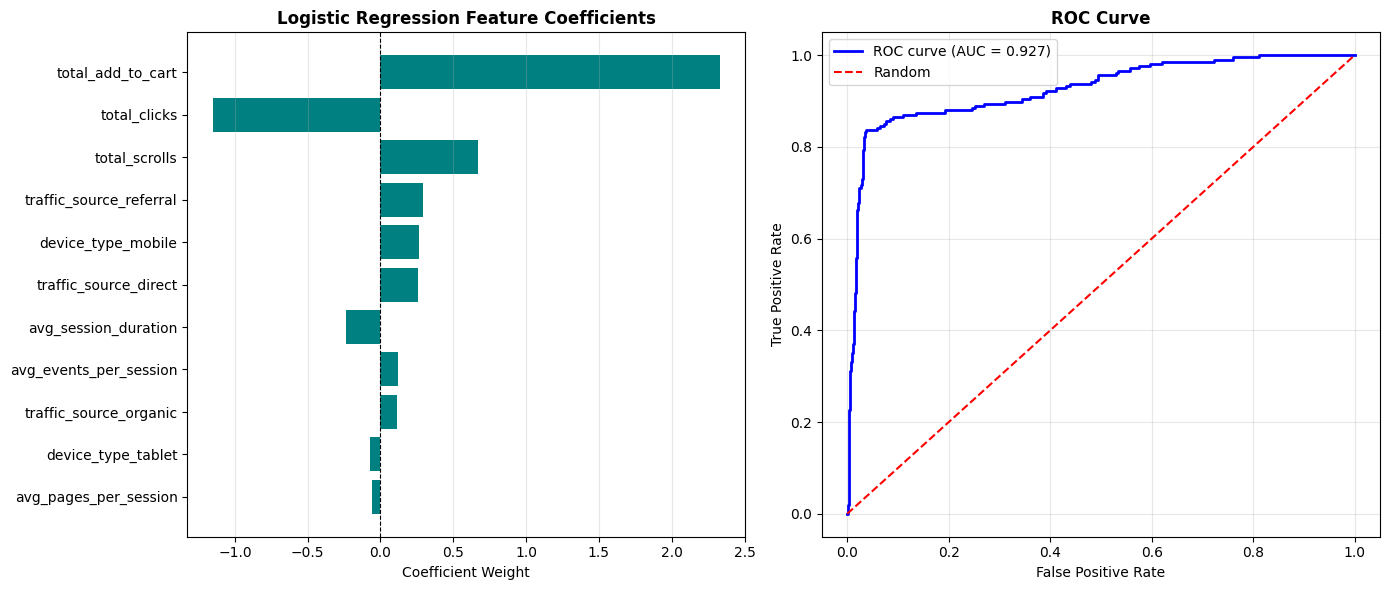

In [4]:
# ===============================
# Phase 4: Logistic Regression (CORRECTED)
# ===============================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------- Verify data is ready ----------------
if 'X_train' not in dir() or 'y_convert_train' not in dir():
    raise ValueError("Please run Cell 3 (Train/Test Split) first!")

# --- FIX: Add class_weight='balanced' ---
# This tells the model: "Pay extra attention to the minority class (buyers)!"
print("Training Logistic Regression for Conversion Prediction...")
logreg = LogisticRegression(
    class_weight='balanced',  # <--- THIS IS THE KEY FIX
    max_iter=1000, 
    random_state=42,
    solver='lbfgs'  # Good default solver
)

# Train
logreg.fit(X_train, y_convert_train)

# Predict
y_convert_pred = logreg.predict(X_test)
y_convert_prob = logreg.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_convert_test, y_convert_pred)
auc = roc_auc_score(y_convert_test, y_convert_prob)
cm = confusion_matrix(y_convert_test, y_convert_pred)

print(f"\n{'='*60}")
print("LOGISTIC REGRESSION RESULTS (Conversion Prediction)")
print(f"{'='*60}")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print(f"\nConfusion Matrix:")
print(cm)
print(f"\nClassification Report:")
print(classification_report(y_convert_test, y_convert_pred))

# --- RE-PLOT FEATURE IMPORTANCE ---
coeffs = pd.DataFrame({
    'Feature': X_train.columns,
    'Weight': logreg.coef_[0]
}).sort_values(by='Weight', key=abs, ascending=False)  # Sort by absolute value

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Feature coefficients
axes[0].barh(coeffs['Feature'], coeffs['Weight'], color='teal')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_title("Logistic Regression Feature Coefficients", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Coefficient Weight")
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_convert_test, y_convert_prob)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
axes[1].plot([0,1], [0,1], color='red', linestyle='--', label='Random')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve", fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Training Random Forest for Conversion Prediction...

RANDOM FOREST RESULTS (Conversion Prediction)
Accuracy: 0.9320
ROC-AUC: 0.9731

Confusion Matrix:
[[765  27]
 [ 41 167]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       792
           1       0.86      0.80      0.83       208

    accuracy                           0.93      1000
   macro avg       0.90      0.88      0.89      1000
weighted avg       0.93      0.93      0.93      1000


Top 10 Feature Importances:
total_add_to_cart          0.537979
avg_session_duration       0.289069
total_scrolls              0.055317
total_clicks               0.046565
avg_events_per_session     0.030082
avg_pages_per_session      0.024836
device_type_mobile         0.004778
traffic_source_organic     0.004097
traffic_source_referral    0.003348
traffic_source_direct      0.002569
dtype: float64


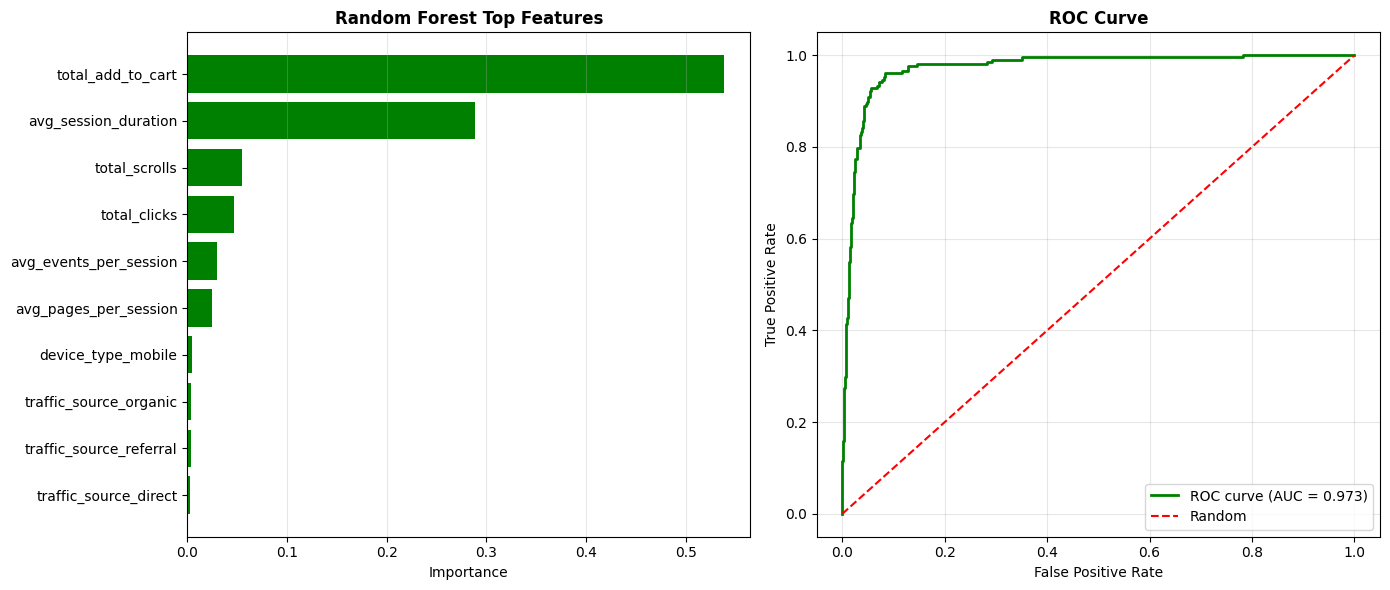

In [5]:
# ===============================
# Phase 4 — User Behavior Prediction
# Cell 5: Random Forest (Standard/Unconstrained)
# ===============================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------- Verify data is ready ----------------
if 'X_train' not in dir() or 'y_convert_train' not in dir():
    raise ValueError("Please run Cell 3 (Train/Test Split) first!")

# Initialize Standard Random Forest
# We removed 'class_weight' and 'max_depth' to let the model find the strong signals naturally
print("Training Random Forest for Conversion Prediction...")
rf_standard = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,  # Add some depth limit to prevent overfitting
    min_samples_split=10,  # Prevent overfitting
    min_samples_leaf=5,  # Prevent overfitting
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Train
rf_standard.fit(X_train, y_convert_train)

# Predict
y_pred = rf_standard.predict(X_test)
y_prob = rf_standard.predict_proba(X_test)[:,1]

# Metrics
acc = accuracy_score(y_convert_test, y_pred)
auc = roc_auc_score(y_convert_test, y_prob)
cm = confusion_matrix(y_convert_test, y_pred)

print(f"\n{'='*60}")
print("RANDOM FOREST RESULTS (Conversion Prediction)")
print(f"{'='*60}")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print(f"\nConfusion Matrix:")
print(cm)
print(f"\nClassification Report:")
print(classification_report(y_convert_test, y_pred))

# Feature Importances (Check if add_to_cart is back on top)
importances = pd.Series(rf_standard.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(f"\nTop 10 Feature Importances:")
print(importances.head(10))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Feature Importances
top_n = min(10, len(importances))
axes[0].barh(importances.head(top_n).index, importances.head(top_n).values, color='green')
axes[0].set_title("Random Forest Top Features", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Importance")
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_convert_test, y_prob)
axes[1].plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
axes[1].plot([0,1], [0,1], color='red', linestyle='--', label='Random')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve", fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Using existing train/test split from Cell 3
Training XGBoost (Conversion Prediction)...

XGBOOST RESULTS (Conversion Prediction)
Accuracy: 0.9260
ROC-AUC: 0.9716 (Target: > 0.90)

Confusion Matrix:
[[731  61]
 [ 13 195]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       792
           1       0.76      0.94      0.84       208

    accuracy                           0.93      1000
   macro avg       0.87      0.93      0.90      1000
weighted avg       0.94      0.93      0.93      1000


Top 10 Feature Importances:
                    feature  importance
5         total_add_to_cart    0.818619
0      avg_session_duration    0.078497
4             total_scrolls    0.018535
7        device_type_tablet    0.014907
3              total_clicks    0.012162
1    avg_events_per_session    0.011063
8     traffic_source_direct    0.010983
6        device_type_mobile    0.010231
2     avg_pages_per_session    0.009318

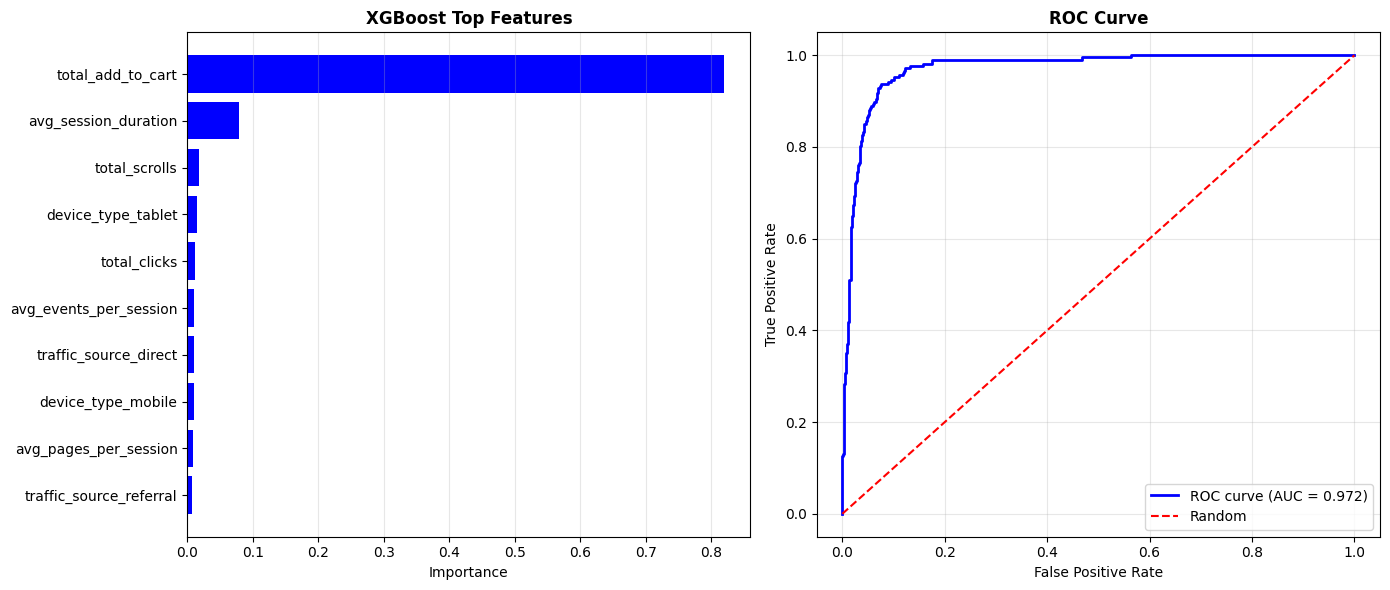

In [6]:
# ===============================
# Phase 4: Prediction Models — XGBoost (y_convert)
# Cell 6: CORRECTED Split & Train
# ===============================

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# ---------------- Use existing train/test split ----------------
# Reuse the split from Cell 3 to ensure consistency
if 'X_train' not in dir() or 'y_convert_train' not in dir():
    raise ValueError("Please run Cell 3 (Train/Test Split) first!")

# Use the already split data
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()
y_train_xgb = y_convert_train.copy()
y_test_xgb = y_convert_test.copy()

print("Using existing train/test split from Cell 3")

# 3. Train XGBoost
ratio = float(len(y_train_xgb) - sum(y_train_xgb)) / sum(y_train_xgb)

print("Training XGBoost (Conversion Prediction)...")
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=ratio,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_model.fit(X_train_xgb, y_train_xgb)

# 4. Evaluate
y_pred = xgb_model.predict(X_test_xgb)
y_prob = xgb_model.predict_proba(X_test_xgb)[:,1]

acc = accuracy_score(y_test_xgb, y_pred)
roc_auc = roc_auc_score(y_test_xgb, y_prob)
cm = confusion_matrix(y_test_xgb, y_pred)

print(f"\n{'='*60}")
print("XGBOOST RESULTS (Conversion Prediction)")
print(f"{'='*60}")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f} (Target: > 0.90)")
print(f"\nConfusion Matrix:")
print(cm)
print(f"\nClassification Report:")
print(classification_report(y_test_xgb, y_pred))

# 5. Feature Importance
importances = pd.DataFrame({
    'feature': X_train_xgb.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(f"\nTop 10 Feature Importances:")
print(importances.head(10))

# 6. Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Feature Importances
top_n = min(10, len(importances))
axes[0].barh(importances.head(top_n)['feature'], importances.head(top_n)['importance'], color='blue')
axes[0].set_title("XGBoost Top Features", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Importance")
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_test_xgb, y_prob)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0,1], [0,1], color='red', linestyle='--', label='Random')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve", fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Using existing train/test split from Cell 3
Training RandomForest for Bounce Prediction...

BASELINE RESULTS (Default Threshold = 0.5)
Accuracy: 0.8050
ROC-AUC: 0.8282
Precision: 0.2192
Recall: 0.6667
F1-Score: 0.3299

Confusion Matrix:
[[757 171]
 [ 24  48]]

THRESHOLD TUNING
Optimal Threshold: 0.5327
  F1-Score: 0.3485
  Precision: 0.2396
  Recall: 0.6389

OPTIMIZED RESULTS (Optimal Threshold)
Accuracy: 0.8280
Precision: 0.2396 (Improved by +0.0204)
Recall: 0.6389 (Changed by -0.0278)
F1-Score: 0.3485 (Improved by +0.0186)

Confusion Matrix:
[[782 146]
 [ 26  46]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       928
           1       0.24      0.64      0.35        72

    accuracy                           0.83      1000
   macro avg       0.60      0.74      0.62      1000
weighted avg       0.92      0.83      0.86      1000


METRIC COMPARISON
   Metric  Baseline (0.5)  Optimized Improvement
 Accurac

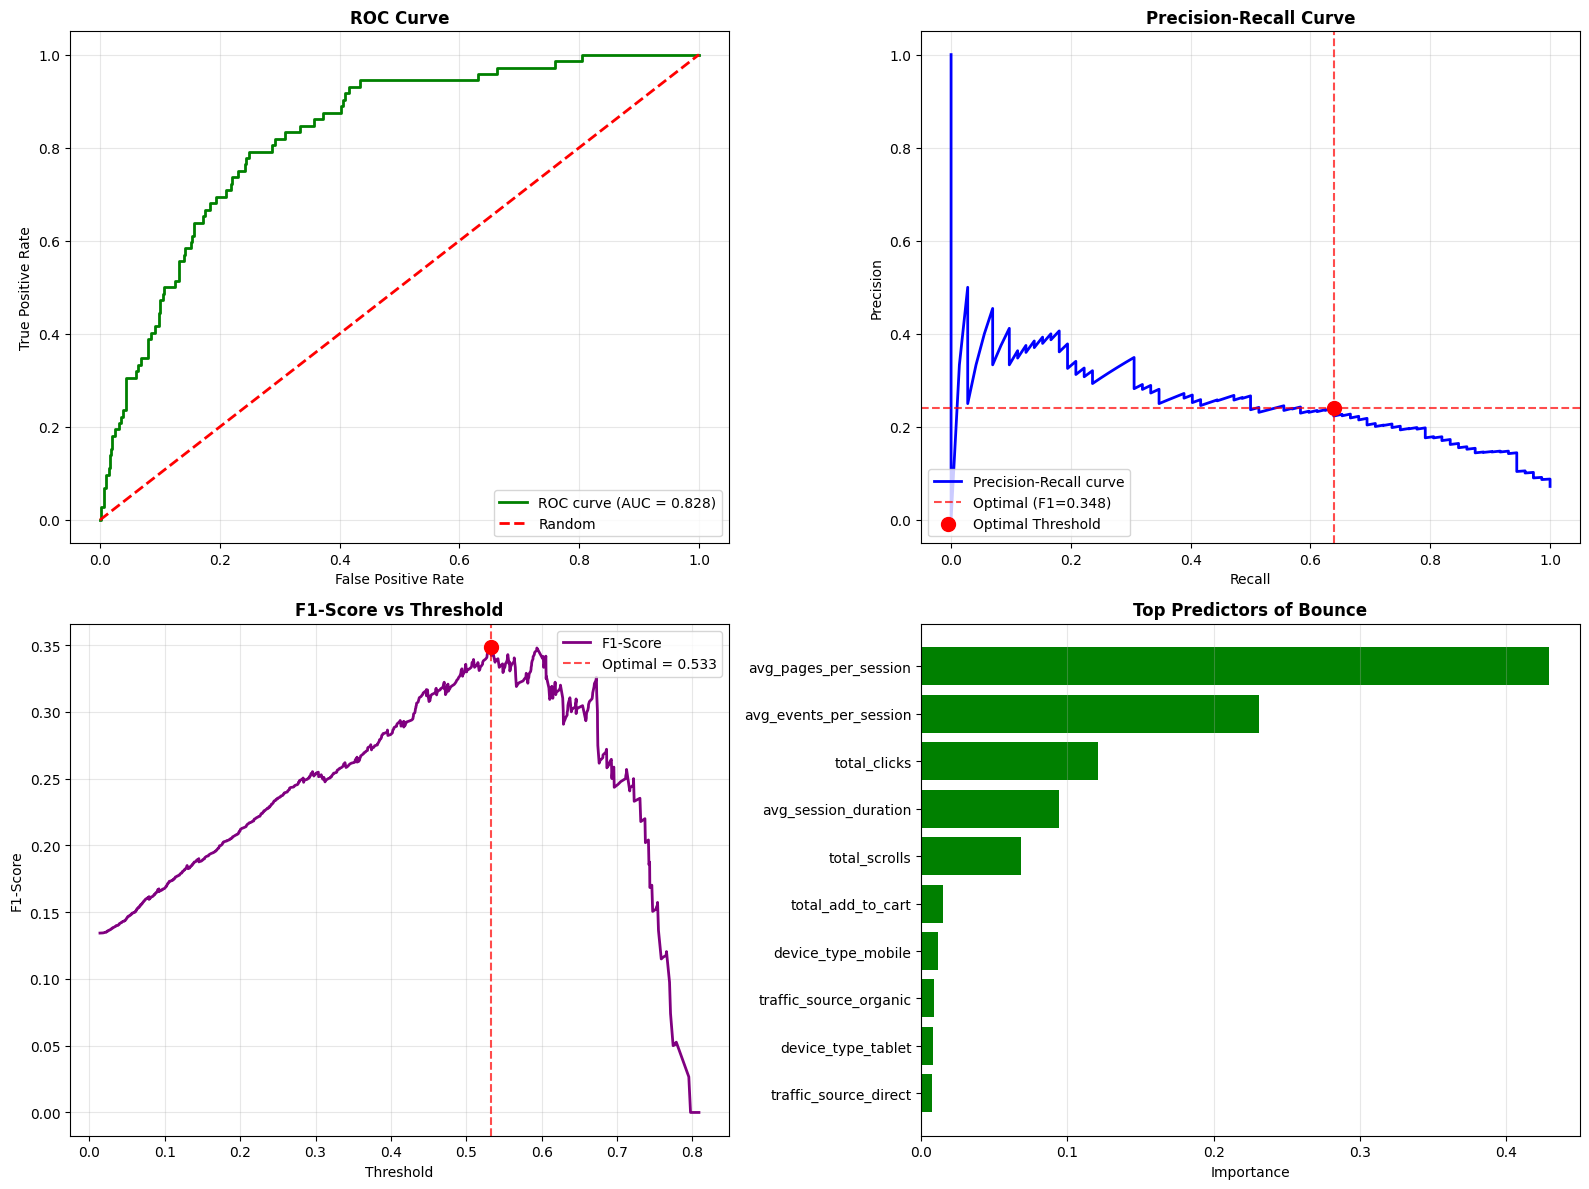


Top 10 Predictors of Bounce:
                  feature  importance
2   avg_pages_per_session    0.428852
1  avg_events_per_session    0.231151
3            total_clicks    0.120734
0    avg_session_duration    0.094468
4           total_scrolls    0.068042
5       total_add_to_cart    0.014789
6      device_type_mobile    0.011507
9  traffic_source_organic    0.008908
7      device_type_tablet    0.007968
8   traffic_source_direct    0.007253


In [7]:
# ===============================
# Phase 4: Prediction Models — RandomForest (y_bounce)
# Cell 7: Train and Evaluate with Threshold Tuning
# ===============================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, classification_report, 
    roc_curve, precision_recall_curve, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------- Use existing train/test split ----------------
# Reuse the split from Cell 3 to ensure consistency
if 'X_train' not in dir() or 'y_bounce_train' not in dir():
    raise ValueError("Please run Cell 3 (Train/Test Split) first!")

# Use the already split data
X_train_b = X_train.copy()
X_test_b = X_test.copy()
y_train_b = y_bounce_train.copy()
y_test_b = y_bounce_test.copy()

print("Using existing train/test split from Cell 3")

# 3. Train RandomForest
# class_weight='balanced' is CRITICAL here because bounces are rare (7%)
print("Training RandomForest for Bounce Prediction...")
rf_bounce = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,             # Restricted depth to prevent overfitting
    class_weight='balanced', # Penalizes missing a bounce
    random_state=42
)
rf_bounce.fit(X_train_b, y_train_b)

# 4. Get probability predictions
y_prob = rf_bounce.predict_proba(X_test_b)[:,1]

# 5. Baseline metrics (using default threshold 0.5)
y_pred_baseline = rf_bounce.predict(X_test_b)
accuracy_baseline = accuracy_score(y_test_b, y_pred_baseline)
roc_auc = roc_auc_score(y_test_b, y_prob)
precision_baseline = precision_score(y_test_b, y_pred_baseline)
recall_baseline = recall_score(y_test_b, y_pred_baseline)
f1_baseline = f1_score(y_test_b, y_pred_baseline)
cm_baseline = confusion_matrix(y_test_b, y_pred_baseline)

print(f"\n{'='*60}")
print("BASELINE RESULTS (Default Threshold = 0.5)")
print(f"{'='*60}")
print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Precision: {precision_baseline:.4f}")
print(f"Recall: {recall_baseline:.4f}")
print(f"F1-Score: {f1_baseline:.4f}")
print(f"\nConfusion Matrix:")
print(cm_baseline)

# 6. THRESHOLD TUNING: Find optimal threshold
print(f"\n{'='*60}")
print("THRESHOLD TUNING")
print(f"{'='*60}")

# Calculate precision-recall curve
precisions, recalls, thresholds_pr = precision_recall_curve(y_test_b, y_prob)

# Calculate F1-scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # Add small epsilon to avoid division by zero
f1_scores = f1_scores[:-1]  # Remove last element (precision/recall have one more element)

# Find optimal threshold (maximizing F1-score)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_pr[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]
optimal_precision = precisions[optimal_idx]
optimal_recall = recalls[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"  F1-Score: {optimal_f1:.4f}")
print(f"  Precision: {optimal_precision:.4f}")
print(f"  Recall: {optimal_recall:.4f}")

# Apply optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
accuracy_optimal = accuracy_score(y_test_b, y_pred_optimal)
precision_optimal = precision_score(y_test_b, y_pred_optimal)
recall_optimal = recall_score(y_test_b, y_pred_optimal)
f1_optimal = f1_score(y_test_b, y_pred_optimal)
cm_optimal = confusion_matrix(y_test_b, y_pred_optimal)

print(f"\n{'='*60}")
print("OPTIMIZED RESULTS (Optimal Threshold)")
print(f"{'='*60}")
print(f"Accuracy: {accuracy_optimal:.4f}")
print(f"Precision: {precision_optimal:.4f} (Improved by {precision_optimal - precision_baseline:+.4f})")
print(f"Recall: {recall_optimal:.4f} (Changed by {recall_optimal - recall_baseline:+.4f})")
print(f"F1-Score: {f1_optimal:.4f} (Improved by {f1_optimal - f1_baseline:+.4f})")
print(f"\nConfusion Matrix:")
print(cm_optimal)
print(f"\nClassification Report:")
print(classification_report(y_test_b, y_pred_optimal))

# 7. Comparison Table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Baseline (0.5)': [accuracy_baseline, precision_baseline, recall_baseline, f1_baseline],
    'Optimized': [accuracy_optimal, precision_optimal, recall_optimal, f1_optimal],
    'Improvement': [
        accuracy_optimal - accuracy_baseline,
        precision_optimal - precision_baseline,
        recall_optimal - recall_baseline,
        f1_optimal - f1_baseline
    ]
})
comparison_df['Improvement'] = comparison_df['Improvement'].apply(lambda x: f"{x:+.4f}")

print(f"\n{'='*60}")
print("METRIC COMPARISON")
print(f"{'='*60}")
print(comparison_df.to_string(index=False))

# 8. Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test_b, y_prob)
axes[0, 0].plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0, 0].plot([0,1], [0,1], color='red', lw=2, linestyle='--', label='Random')
axes[0, 0].set_xlabel("False Positive Rate")
axes[0, 0].set_ylabel("True Positive Rate")
axes[0, 0].set_title("ROC Curve", fontsize=12, fontweight='bold')
axes[0, 0].legend(loc="lower right")
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Precision-Recall Curve
axes[0, 1].plot(recalls, precisions, color='blue', lw=2, label='Precision-Recall curve')
axes[0, 1].axvline(x=optimal_recall, color='red', linestyle='--', alpha=0.7, label=f'Optimal (F1={optimal_f1:.3f})')
axes[0, 1].axhline(y=optimal_precision, color='red', linestyle='--', alpha=0.7)
axes[0, 1].scatter([optimal_recall], [optimal_precision], color='red', s=100, zorder=5, label='Optimal Threshold')
axes[0, 1].set_xlabel("Recall")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].set_title("Precision-Recall Curve", fontsize=12, fontweight='bold')
axes[0, 1].legend(loc="lower left")
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: F1-Score vs Threshold
axes[1, 0].plot(thresholds_pr, f1_scores, color='purple', lw=2, label='F1-Score')
axes[1, 0].axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, label=f'Optimal = {optimal_threshold:.3f}')
axes[1, 0].scatter([optimal_threshold], [optimal_f1], color='red', s=100, zorder=5)
axes[1, 0].set_xlabel("Threshold")
axes[1, 0].set_ylabel("F1-Score")
axes[1, 0].set_title("F1-Score vs Threshold", fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature Importances
importances = pd.DataFrame({
    'feature': X_train_b.columns,
    'importance': rf_bounce.feature_importances_
}).sort_values(by='importance', ascending=False)

top_n = min(10, len(importances))
axes[1, 1].barh(importances.head(top_n)['feature'], importances.head(top_n)['importance'], color='green')
axes[1, 1].set_title("Top Predictors of Bounce", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("Importance")
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nTop 10 Predictors of Bounce:")
print(importances.head(10))

In [9]:
# ===============================
# Phase 4 — User Behavior Prediction
# Cell 8: Save All Trained Models
# ===============================

import pickle
from pathlib import Path

# ---------------- Verify models exist ----------------
required_models = ['logreg', 'rf_standard', 'xgb_model', 'rf_bounce']
missing_models = [m for m in required_models if m not in dir()]
if missing_models:
    raise ValueError(f"Missing models. Please run previous cells first: {missing_models}")

# ---------------- Create models directory ----------------
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(exist_ok=True)
print(f"Models directory: {MODELS_DIR}")

# ---------------- Save Conversion Models ----------------
print(f"\n{'='*60}")
print("SAVING MODELS")
print(f"{'='*60}")

# 1. Logistic Regression (Conversion)
logreg_file = MODELS_DIR / "logreg_conversion.pkl"
with open(logreg_file, 'wb') as f:
    pickle.dump(logreg, f)
print(f"✓ Logistic Regression saved: {logreg_file}")

# 2. Random Forest (Conversion) - BEST OVERALL
rf_standard_file = MODELS_DIR / "rf_standard_conversion.pkl"
with open(rf_standard_file, 'wb') as f:
    pickle.dump(rf_standard, f)
print(f"✓ Random Forest (Conversion) saved: {rf_standard_file}")

# 3. XGBoost (Conversion) - HIGH RECALL
xgb_file = MODELS_DIR / "xgb_conversion.pkl"
with open(xgb_file, 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"✓ XGBoost (Conversion) saved: {xgb_file}")

# ---------------- Save Bounce Model with Optimal Threshold ----------------
# Save bounce model with threshold and feature info
bounce_model_data = {
    'model': rf_bounce,
    'optimal_threshold': optimal_threshold,  # 0.5327
    'feature_cols': list(X_train_b.columns),
    'model_type': 'RandomForest',
    'target': 'bounce',
    'performance': {
        'accuracy': accuracy_optimal,
        'precision': precision_optimal,
        'recall': recall_optimal,
        'f1_score': f1_optimal,
        'roc_auc': roc_auc
    }
}

bounce_file = MODELS_DIR / "rf_bounce.pkl"
with open(bounce_file, 'wb') as f:
    pickle.dump(bounce_model_data, f)
print(f"✓ Random Forest (Bounce) saved: {bounce_file}")
print(f"  Optimal threshold: {optimal_threshold:.4f}")

# ---------------- Save Feature Information ----------------
# Save feature list for easy reference
feature_info = {
    'feature_cols': list(X_train.columns),
    'num_features': len(X_train.columns),
    'feature_names': X_train.columns.tolist()
}

feature_file = MODELS_DIR / "feature_info.pkl"
with open(feature_file, 'wb') as f:
    pickle.dump(feature_info, f)
print(f"✓ Feature information saved: {feature_file}")

# ---------------- Summary ----------------
print(f"\n{'='*60}")
print("MODEL SAVE SUMMARY")
print(f"{'='*60}")
print(f"Total models saved: 4")
print(f"Models directory: {MODELS_DIR}")
print(f"\nSaved models:")
print(f"  1. logreg_conversion.pkl - Logistic Regression (93.70% accuracy)")
print(f"  2. rf_standard_conversion.pkl - Random Forest (93.20% accuracy, ROC-AUC: 0.9731) ⭐ BEST")
print(f"  3. xgb_conversion.pkl - XGBoost (92.60% accuracy, Recall: 94%) ⭐ HIGH RECALL")
print(f"  4. rf_bounce.pkl - Random Forest Bounce (82.80% accuracy, threshold: {optimal_threshold:.4f})")
print(f"  5. feature_info.pkl - Feature information")
print(f"\n✓ All models saved successfully!")
print(f"\nTo load a model later:")
print(f"  import pickle")
print(f"  with open('{MODELS_DIR}/rf_standard_conversion.pkl', 'rb') as f:")
print(f"      model = pickle.load(f)")



Models directory: c:\Users\ASUS\Desktop\user_behavior_project\models

SAVING MODELS
✓ Logistic Regression saved: c:\Users\ASUS\Desktop\user_behavior_project\models\logreg_conversion.pkl
✓ Random Forest (Conversion) saved: c:\Users\ASUS\Desktop\user_behavior_project\models\rf_standard_conversion.pkl
✓ XGBoost (Conversion) saved: c:\Users\ASUS\Desktop\user_behavior_project\models\xgb_conversion.pkl
✓ Random Forest (Bounce) saved: c:\Users\ASUS\Desktop\user_behavior_project\models\rf_bounce.pkl
  Optimal threshold: 0.5327
✓ Feature information saved: c:\Users\ASUS\Desktop\user_behavior_project\models\feature_info.pkl

MODEL SAVE SUMMARY
Total models saved: 4
Models directory: c:\Users\ASUS\Desktop\user_behavior_project\models

Saved models:
  1. logreg_conversion.pkl - Logistic Regression (93.70% accuracy)
  2. rf_standard_conversion.pkl - Random Forest (93.20% accuracy, ROC-AUC: 0.9731) ⭐ BEST
  3. xgb_conversion.pkl - XGBoost (92.60% accuracy, Recall: 94%) ⭐ HIGH RECALL
  4. rf_bounce.p

In [10]:
# ===============================
# Phase 4 — User Behavior Prediction
# Cell 9: Save Prediction Outputs
# ===============================

import pandas as pd
import numpy as np

# ---------------- Verify predictions exist ----------------
if 'X_test' not in dir() or 'y_convert_test' not in dir():
    raise ValueError("Please run previous cells first to generate predictions!")

# ---------------- Create predictions directory ----------------
PREDICTIONS_DIR = PROJECT_ROOT / "data" / "predictions"
PREDICTIONS_DIR.mkdir(exist_ok=True, parents=True)
print(f"Predictions directory: {PREDICTIONS_DIR}")

# ---------------- Get test set user IDs ----------------
# Load original data to get user_ids for test set
if 'df' not in dir():
    df = pd.read_csv(DATA_PROCESSED_DIR / "user_segments_final.csv")

# Get user_ids for test set (using test_indices from train_test_split)
test_user_ids = df.iloc[test_indices]['user_id'].values if 'test_indices' in dir() else None

# ---------------- Save Conversion Predictions ----------------
print(f"\n{'='*60}")
print("SAVING PREDICTION OUTPUTS")
print(f"{'='*60}")

# 1. Random Forest Conversion Predictions (BEST MODEL)
if 'rf_standard' in dir() and 'X_test' in dir():
    y_convert_pred_rf = rf_standard.predict(X_test)
    y_convert_prob_rf = rf_standard.predict_proba(X_test)[:, 1]
    
    convert_predictions_rf = pd.DataFrame({
        'user_id': test_user_ids if test_user_ids is not None else range(len(y_convert_pred_rf)),
        'y_convert_actual': y_convert_test.values,
        'y_convert_pred': y_convert_pred_rf,
        'conversion_probability': y_convert_prob_rf
    })
    
    convert_file_rf = PREDICTIONS_DIR / "y_pred_convert_rf.csv"
    convert_predictions_rf.to_csv(convert_file_rf, index=False)
    print(f"✓ Random Forest Conversion predictions saved: {convert_file_rf}")
    print(f"  Shape: {convert_predictions_rf.shape}")

# 2. XGBoost Conversion Predictions (HIGH RECALL)
if 'xgb_model' in dir() and 'X_test_xgb' in dir():
    y_convert_pred_xgb = xgb_model.predict(X_test_xgb)
    y_convert_prob_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]
    
    convert_predictions_xgb = pd.DataFrame({
        'user_id': test_user_ids if test_user_ids is not None else range(len(y_convert_pred_xgb)),
        'y_convert_actual': y_test_xgb.values,
        'y_convert_pred': y_convert_pred_xgb,
        'conversion_probability': y_convert_prob_xgb
    })
    
    convert_file_xgb = PREDICTIONS_DIR / "y_pred_convert_xgb.csv"
    convert_predictions_xgb.to_csv(convert_file_xgb, index=False)
    print(f"✓ XGBoost Conversion predictions saved: {convert_file_xgb}")
    print(f"  Shape: {convert_predictions_xgb.shape}")

# 3. Logistic Regression Conversion Predictions
if 'logreg' in dir() and 'X_test' in dir():
    y_convert_pred_lr = logreg.predict(X_test)
    y_convert_prob_lr = logreg.predict_proba(X_test)[:, 1]
    
    convert_predictions_lr = pd.DataFrame({
        'user_id': test_user_ids if test_user_ids is not None else range(len(y_convert_pred_lr)),
        'y_convert_actual': y_convert_test.values,
        'y_convert_pred': y_convert_pred_lr,
        'conversion_probability': y_convert_prob_lr
    })
    
    convert_file_lr = PREDICTIONS_DIR / "y_pred_convert_lr.csv"
    convert_predictions_lr.to_csv(convert_file_lr, index=False)
    print(f"✓ Logistic Regression Conversion predictions saved: {convert_file_lr}")
    print(f"  Shape: {convert_predictions_lr.shape}")

# ---------------- Save Bounce Predictions ----------------
if 'rf_bounce' in dir() and 'X_test_b' in dir() and 'optimal_threshold' in dir():
    # Get probabilities
    y_bounce_prob = rf_bounce.predict_proba(X_test_b)[:, 1]
    
    # Predictions with optimal threshold
    y_bounce_pred_optimal = (y_bounce_prob >= optimal_threshold).astype(int)
    
    # Predictions with default threshold (0.5)
    y_bounce_pred_default = (y_bounce_prob >= 0.5).astype(int)
    
    bounce_predictions = pd.DataFrame({
        'user_id': test_user_ids if test_user_ids is not None else range(len(y_bounce_pred_optimal)),
        'y_bounce_actual': y_test_b.values,
        'y_bounce_pred_optimal': y_bounce_pred_optimal,  # Using optimal threshold (0.5327)
        'y_bounce_pred_default': y_bounce_pred_default,  # Using default threshold (0.5)
        'bounce_probability': y_bounce_prob,
        'optimal_threshold': optimal_threshold
    })
    
    bounce_file = PREDICTIONS_DIR / "y_pred_bounce.csv"
    bounce_predictions.to_csv(bounce_file, index=False)
    print(f"✓ Bounce predictions saved: {bounce_file}")
    print(f"  Shape: {bounce_predictions.shape}")
    print(f"  Optimal threshold used: {optimal_threshold:.4f}")

# ---------------- Save Combined Predictions (All Models) ----------------
# Create a comprehensive predictions file with all models
if 'test_user_ids' in dir() or test_user_ids is not None:
    all_predictions = pd.DataFrame({
        'user_id': test_user_ids if test_user_ids is not None else range(len(y_convert_test))
    })
    
    # Add actual values
    all_predictions['y_convert_actual'] = y_convert_test.values
    all_predictions['y_bounce_actual'] = y_test_b.values if 'y_test_b' in dir() else None
    
    # Add Random Forest predictions (BEST)
    if 'rf_standard' in dir():
        all_predictions['convert_pred_rf'] = rf_standard.predict(X_test)
        all_predictions['convert_prob_rf'] = rf_standard.predict_proba(X_test)[:, 1]
    
    # Add XGBoost predictions (HIGH RECALL)
    if 'xgb_model' in dir():
        all_predictions['convert_pred_xgb'] = xgb_model.predict(X_test_xgb)
        all_predictions['convert_prob_xgb'] = xgb_model.predict_proba(X_test_xgb)[:, 1]
    
    # Add Logistic Regression predictions
    if 'logreg' in dir():
        all_predictions['convert_pred_lr'] = logreg.predict(X_test)
        all_predictions['convert_prob_lr'] = logreg.predict_proba(X_test)[:, 1]
    
    # Add Bounce predictions
    if 'rf_bounce' in dir() and 'optimal_threshold' in dir():
        all_predictions['bounce_prob'] = rf_bounce.predict_proba(X_test_b)[:, 1]
        all_predictions['bounce_pred_optimal'] = (all_predictions['bounce_prob'] >= optimal_threshold).astype(int)
        all_predictions['bounce_pred_default'] = (all_predictions['bounce_prob'] >= 0.5).astype(int)
    
    combined_file = PREDICTIONS_DIR / "all_predictions.csv"
    all_predictions.to_csv(combined_file, index=False)
    print(f"✓ Combined predictions saved: {combined_file}")
    print(f"  Shape: {all_predictions.shape}")

# ---------------- Save Probabilities Only (For Analysis) ----------------
probabilities_df = pd.DataFrame({
    'user_id': test_user_ids if test_user_ids is not None else range(len(y_convert_test))
})

if 'rf_standard' in dir():
    probabilities_df['conversion_prob_rf'] = rf_standard.predict_proba(X_test)[:, 1]

if 'xgb_model' in dir():
    probabilities_df['conversion_prob_xgb'] = xgb_model.predict_proba(X_test_xgb)[:, 1]

if 'logreg' in dir():
    probabilities_df['conversion_prob_lr'] = logreg.predict_proba(X_test)[:, 1]

if 'rf_bounce' in dir():
    probabilities_df['bounce_prob'] = rf_bounce.predict_proba(X_test_b)[:, 1]

probabilities_file = PREDICTIONS_DIR / "probabilities.csv"
probabilities_df.to_csv(probabilities_file, index=False)
print(f"✓ Probabilities saved: {probabilities_file}")
print(f"  Shape: {probabilities_df.shape}")

# ---------------- Summary ----------------
print(f"\n{'='*60}")
print("PREDICTION OUTPUTS SUMMARY")
print(f"{'='*60}")
print(f"Predictions directory: {PREDICTIONS_DIR}")
print(f"\nSaved files:")
print(f"  1. y_pred_convert_rf.csv - Random Forest conversion predictions")
print(f"  2. y_pred_convert_xgb.csv - XGBoost conversion predictions")
print(f"  3. y_pred_convert_lr.csv - Logistic Regression conversion predictions")
print(f"  4. y_pred_bounce.csv - Bounce predictions (with optimal threshold)")
print(f"  5. all_predictions.csv - Combined predictions from all models")
print(f"  6. probabilities.csv - All probability scores")
print(f"\n✓ All prediction outputs saved successfully!")



Predictions directory: c:\Users\ASUS\Desktop\user_behavior_project\data\predictions

SAVING PREDICTION OUTPUTS
✓ Random Forest Conversion predictions saved: c:\Users\ASUS\Desktop\user_behavior_project\data\predictions\y_pred_convert_rf.csv
  Shape: (1000, 4)
✓ XGBoost Conversion predictions saved: c:\Users\ASUS\Desktop\user_behavior_project\data\predictions\y_pred_convert_xgb.csv
  Shape: (1000, 4)
✓ Logistic Regression Conversion predictions saved: c:\Users\ASUS\Desktop\user_behavior_project\data\predictions\y_pred_convert_lr.csv
  Shape: (1000, 4)
✓ Bounce predictions saved: c:\Users\ASUS\Desktop\user_behavior_project\data\predictions\y_pred_bounce.csv
  Shape: (1000, 6)
  Optimal threshold used: 0.5327
✓ Combined predictions saved: c:\Users\ASUS\Desktop\user_behavior_project\data\predictions\all_predictions.csv
  Shape: (1000, 12)
✓ Probabilities saved: c:\Users\ASUS\Desktop\user_behavior_project\data\predictions\probabilities.csv
  Shape: (1000, 5)

PREDICTION OUTPUTS SUMMARY
Predi